# IEEE-CIS Fraud Detection: Neo4j Loader

This notebook demonstrates how to load the [IEEE-CIS Fraud Detection dataset](https://www.kaggle.com/c/ieee-fraud-detection) into a Neo4j Graph Database. The goal is to transform flat tabular data containing transactions and identity information into a property graph model to enable graph-based fraud analysis.

## The IEEE-CIS Fraud Dataset

The **IEEE-CIS Fraud Detection dataset** was released in 2019 by **Vesta Corporation** (a leader in guaranteed e-commerce payment solutions) in partnership with the **IEEE Computational Intelligence Society**.

Unlike many synthetic datasets (like PaySim), this contains **real-world e-commerce transactions**, which makes it uniquely messy, highly imbalanced, and rich in the "hidden links" that graph databases are designed to uncover.

### Data Structure and Scale

The dataset is split into two primary tables that are joined by a unique `TransactionID`:

* **Transaction Table (`train_transaction.csv`):** Contains the core payment data.
* **Scale:** ~590,000 transactions.
* **Target:** `isFraud` (Binary: 1 if fraudulent, 0 if legitimate).
* **Key Attributes:** Transaction amount (`TransactionAmt`), product code, and card information (Card type, issuer, etc.).


* **Identity Table (`train_identity.csv`):** Contains the digital fingerprint of the user performing the transaction.
* **Scale:** Only about 25% of transactions have associated identity data.
* **Key Attributes:** Network information (IP, Email domain), Device information (OS, Browser, Device Type), and various hardware/software IDs.



### Feature Categories (The "Graph DNA")

To build the Neo4j graph you are using, the following feature groups are treated as **Nodes** or **Edges**:

* **Card Info (`card1` - `card6`):** This includes the Bank Identification Number (BIN), card type (Debit/Credit), and the card brand (Visa/Mastercard). In a graph, these represent the primary payment instruments.
* **Address and Distance (`addr1`, `addr2`, `dist1`, `dist2`):** Masked geographic data. `addr1` often represents the billing zip code, while `addr2` represents the country.
* **Email Domains (`P_emaildomain`, `R_emaildomain`):** Purchaser and Recipient email providers. These are vital for detecting "Disposable Email" rings.
* **The V-Features (`V1` - `V339`):** These are engineered features provided by Vesta. They include rankings, counts, and other relations (e.g., how many times this IP was seen in the last 24 hours). While highly predictive, they are **obfuscated**, meaning we don't know their exact real-world names, but their mathematical patterns remain intact for ML models.
* **The D-Features (`D1` - `D15`):** Time deltas. These represent the time between transactions or since the card was first seen. These are the foundation for the **Temporal Analysis** (Velocity) you performed in your notebook.

### Why this dataset is perfect for Neo4j

Traditional SQL databases struggle with this dataset because the "Identity" information is sparse. In a Graph Database, we turn these sparse attributes into "Hubs":

1. **Shared Identity Hubs:** If five different `CardID` nodes all point to the same `DeviceID` node, Neo4j reveals a community instantly.
2. **The "Cold Start" Problem:** Many fraudsters use a card only once and then discard it. By looking at the **Device** or **IP** node instead of the **Card** node, we can link a new "clean" card to a known "dirty" piece of hardware.
3. **Community Density:** As you discovered with **Community 1**, fraud in this dataset is not distributed evenly. It clusters heavily around specific browsers (`id_31`) or Operating Systems (`id_30`) that are easier for fraudsters to spoof or automate.

### Anonymization and PII

This dataset is a textbook example of **Pseudonymization**. In the majority of cases, fraud, data science and engineering teams do not have access to personal information in the datasets they handle. Instead, they use **Pseudonyms** to represent real-world entities. 

* **No Real Names:** You will not find "John Doe."
* **Masked IDs:** Device IDs and IP addresses are replaced with unique hashes or categorical integers.
* **Obfuscated Features:** The `id_01` to `id_38` columns represent sensitive attributes (like proxy usage or screen resolution) that have been transformed into numerical or categorical formats to prevent the identification of specific individuals while preserving the "behavioral signature" required for Machine Learning.

### Challenges for Fraud Teams

* **Imbalance:** The fraud rate is typically only ~3.5%. Graph communities (like "Fraud Islands") are essential to boost this signal.
* **Temporal Shift:** Fraudster behavior changes over time. **Velocity Analysis** is the primary way to detect when a ring has moved from "testing" cards to "draining" them.

## Environment and Configuration
First, we load necessary libraries and environment variables. We rely on a `.env` file to securely store Neo4j credentials.

In [1]:
# Load .env variables
from dotenv import load_dotenv
import os
import logging

load_dotenv()

NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE")

# Set the logging level for the 'neo4j' module to ERROR
logging.getLogger("neo4j").setLevel(logging.ERROR)

In [2]:
# Download the https://www.kaggle.com/competitions/ieee-fraud-detection dataset
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.competition_download_files('ieee-fraud-detection', path='./.data', quiet=False)

# Unzip the downloaded files
import zipfile

with zipfile.ZipFile('./.data/ieee-fraud-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./.data')

ieee-fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


## Loading Data into Pandas
Here we read the CSV files into Pandas DataFrames to inspect the structure and prepare for graph ingestion. We handle both the transaction and identity portions for training and testing.

In [3]:
# Load train and test datasets
import pandas as pd

train_transaction_df = pd.read_csv('./.data/train_transaction.csv')
test_transaction_df = pd.read_csv('./.data/test_transaction.csv')

train_identity_df = pd.read_csv('./.data/train_identity.csv')
test_identity_df = pd.read_csv('./.data/test_identity.csv')

# Show the shape of the datasets
print(f'Transaction Shape (train): {train_transaction_df.shape}')
print(f'Identity Shape (train): {train_identity_df.shape}')
print(f'Transaction Shape (test): {test_transaction_df.shape}')
print(f'Identity Shape (test): {test_identity_df.shape}')

Transaction Shape (train): (590540, 394)
Identity Shape (train): (144233, 41)
Transaction Shape (test): (506691, 393)
Identity Shape (test): (141907, 41)


## Feature Analysis: Transaction Table
The dataset documentation defines specific columns as categorical (e.g., `ProductCD`, `addr1`, `card1`-`card6`). We separate these from numerical features to better understand the schema we are mapping.

In [4]:
# Specific transaction categorical columns as defined by the competition
ieee_transaction_cat_features = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 
    'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'
]

# Cleanly separate
actual_cat = [c for c in train_transaction_df.columns if c in ieee_transaction_cat_features]
actual_num = [c for c in train_transaction_df.columns if c not in ieee_transaction_cat_features and c != 'isFraud']

print(f'Categorical Transaction Features: {actual_cat}')
print(f'Numerical Transaction Features: {actual_num}')

Categorical Transaction Features: ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
Numerical Transaction Features: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V

## Feature Analysis: Identity Table
Similarly, the identity table contains variables `id_01` through `id_38`. Variables `id_12` to `id_38` are categorical, representing technical fingerprints like device signatures, screen resolutions, and OS versions.

In [5]:
# Specific identiry categorical columns as defined by the competition
ieee_identity_cat_features = [col for col in train_identity_df.columns if col.startswith('id_') 
                      and int(col.split('_')[-1]) in range(12, 39)]

actual_identity_cat = [c for c in train_identity_df.columns if c in ieee_identity_cat_features]
actual_identity_num = [c for c in train_identity_df.columns if c not in ieee_identity_cat_features]

print(f'Categorical Identity Features: {actual_identity_cat}')
print(f'Numerical Identity Features: {actual_identity_num}')

Categorical Identity Features: ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
Numerical Identity Features: ['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'DeviceType', 'DeviceInfo']


## Exploratory Data Analysis (EDA)

### Temporal Distribution
`TransactionDT` represents a timedelta from a given reference datetime (not an actual timestamp). We visualize the distribution to see how the Train and Test sets align temporally.

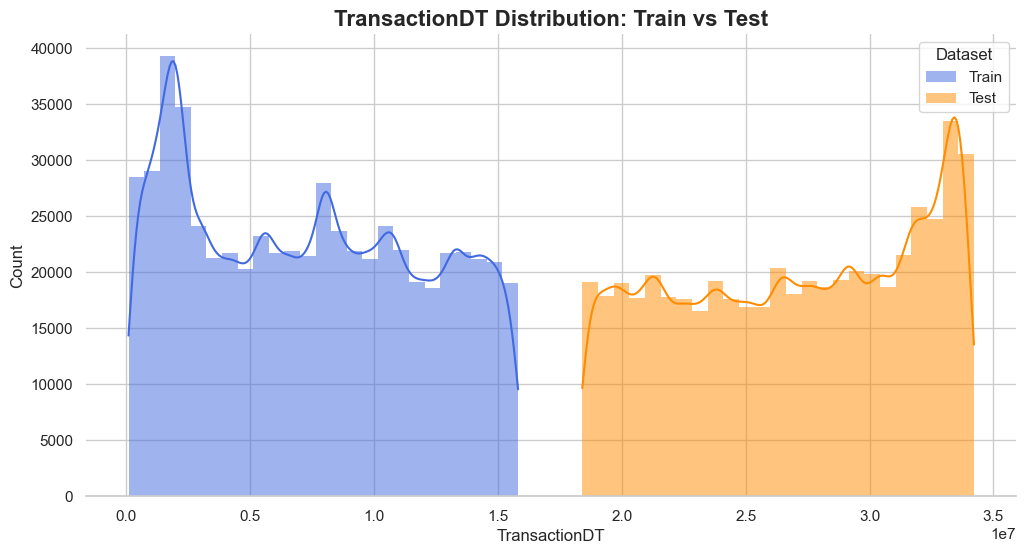

In [6]:
# Plot transaction_dt for both the train and test datasets, in the same plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(data=train_transaction_df, x='TransactionDT', bins=25, label='Train', color='royalblue', kde=True, alpha=0.5, linewidth=0)
sns.histplot(data=test_transaction_df, x='TransactionDT', bins=25, label='Test', color='darkorange', kde=True, alpha=0.5, linewidth=0)

plt.xlabel('TransactionDT', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('TransactionDT Distribution: Train vs Test', fontsize=16, fontweight='bold')
plt.legend(title='Dataset')

# Clean up the plot borders
sns.despine(left=True)

plt.show()

### V-Features (Vesta Engineered)
The 'V' features are rich features engineered by Vesta, likely including ranking, counting, and other entity-relation characteristics. We visualize the correlation heatmap to check for redundancy.

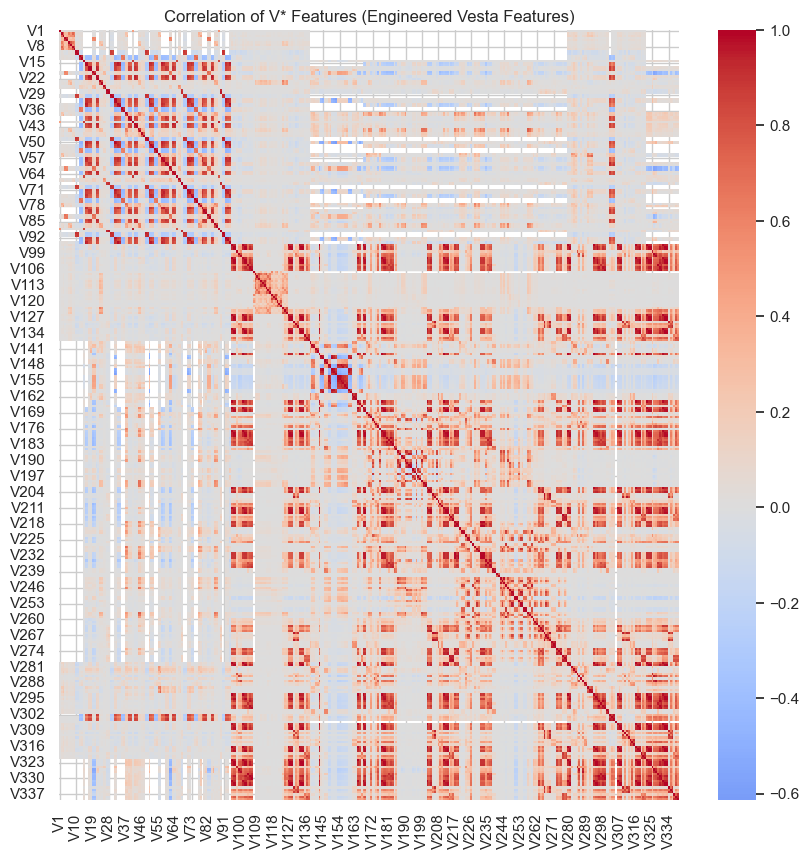

In [7]:
# Select all V* features
v_cols = [col for col in train_transaction_df.columns if col.startswith('V')]
plt.figure(figsize=(10, 10))
sns.heatmap(train_transaction_df[v_cols].corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation of V* Features (Engineered Vesta Features)')
plt.show()

### M-Features (Match)
The 'M' features (M1-M9) are boolean indicators (Match) such as "names on card match address," etc. We look at the fraud distribution across these categories.

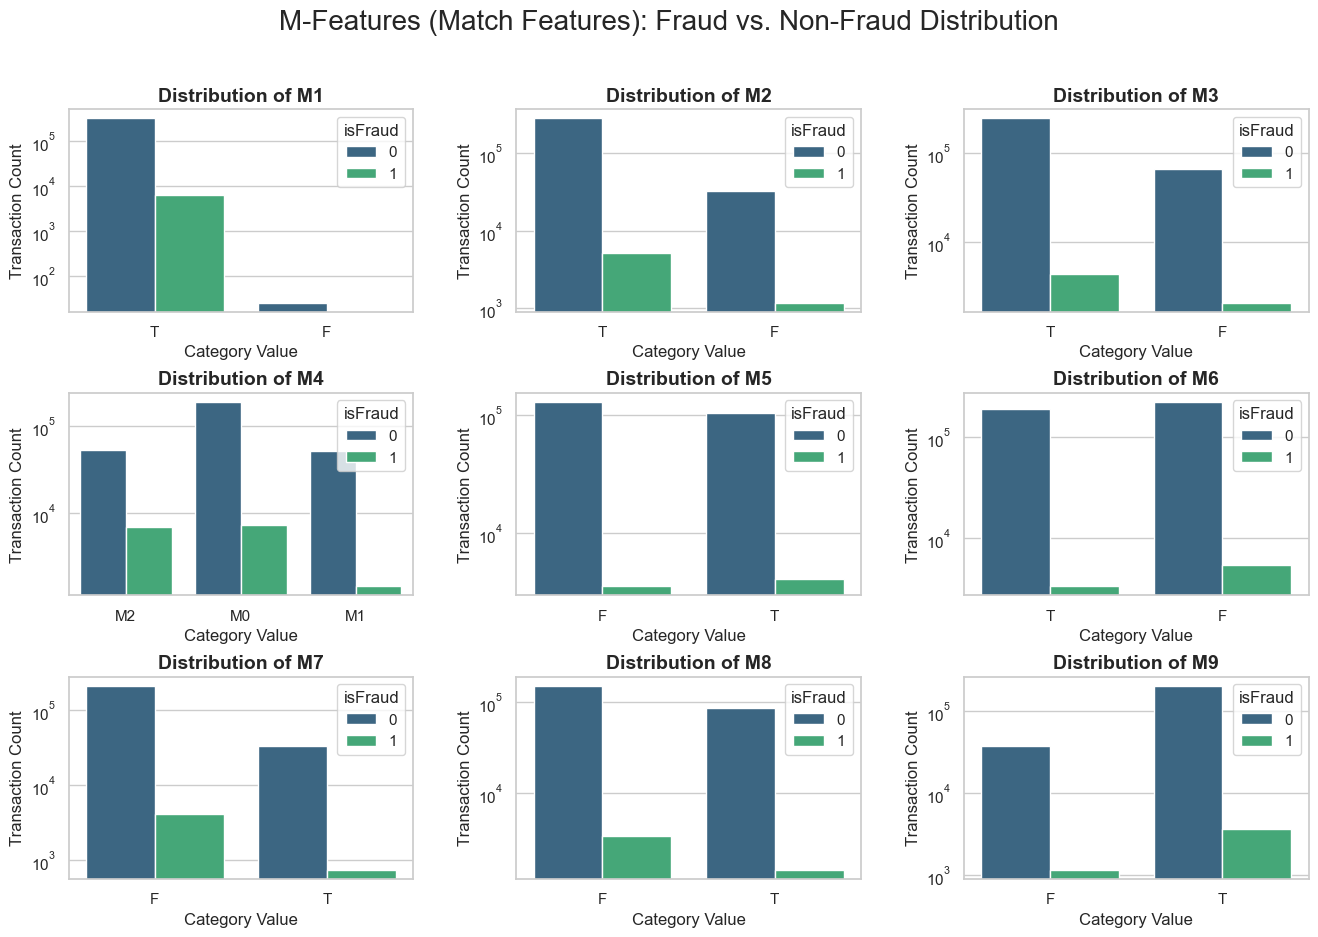

In [8]:
# Select all M* features
m_cols = [col for col in train_transaction_df.columns if col.startswith('M')]

fig, axes = plt.subplots(3, 3, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, col in enumerate(m_cols):
    ax = axes[i // 3, i % 3]
    
    # Calculate percentages for the 'hue' to show fraud density
    # We use a countplot with isFraud as the color
    sns.countplot(data=train_transaction_df, x=col, hue='isFraud', ax=ax, palette='viridis')
    
    # Customizing each subplot
    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Category Value')
    ax.set_ylabel('Transaction Count')
    ax.legend(title='isFraud', loc='upper right')
    
    # Optional: Log scale if the data is highly imbalanced
    ax.set_yscale('log')

plt.suptitle('M-Features (Match Features): Fraud vs. Non-Fraud Distribution', fontsize=20)
plt.show()

### C-Features (Counting)
The 'C' features are counting features (e.g., how many addresses are associated with the payment card?). We use Spearman correlation here as these counts likely have non-linear relationships.

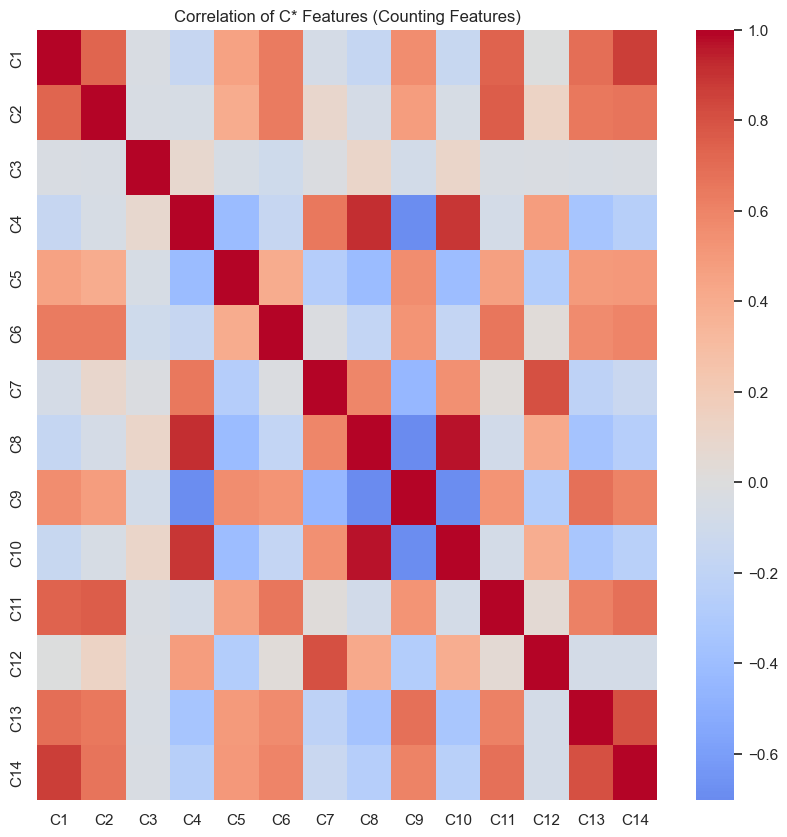

In [9]:
# Select all C* features
c_cols = [col for col in train_transaction_df.columns if col.startswith('C')]
plt.figure(figsize=(10, 10))

# We use spearman correlation because it handles non-linear relationships better
corr = train_transaction_df[c_cols].corr(method='spearman')

sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation of C* Features (Counting Features)')
plt.show()

## Data Preparation
Before ingesting into Neo4j, we merge the Transaction and Identity tables on `TransactionID` to create a unified view of each event. This simplifies the graph mapping process.

In [10]:
# Merge identity and transaction datasets
train_df = pd.merge(train_transaction_df, train_identity_df, on='TransactionID', how='left')
test_df = pd.merge(test_transaction_df, test_identity_df, on='TransactionID', how='left')

print(f'Train shape after merge: {train_df.shape}')
print(f'Test shape after merge: {test_df.shape}')

train_df.head()

Train shape after merge: (590540, 434)
Test shape after merge: (506691, 433)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Graph Modeling and Ingestion

### The Graph Model
We transform the flat table into a star-like schema centered on the **Transaction**:
- `(Transaction)-[:USED_CARD]->(Card)`
- `(Transaction)-[:BILLED_TO]->(Address)`
- `(Transaction)-[:PURCHASER_EMAIL]->(Email)`
- `(Transaction)-[:ON_DEVICE]->(Device)`

This structure allows us to link disparate transactions that share common entities (e.g., different transactions using the same card or device). We use `UNWIND` for batch processing in Cypher.

In [11]:
from neo4j import GraphDatabase
import numpy as np
from tqdm.auto import tqdm

def load_merged_df_to_neo4j(df, uri, auth, database):
    driver = GraphDatabase.driver(uri, auth=auth)
    
    # Select and Clean Data
    # Converting to dict handles NaNs better if we replace them with None first
    # We use a copy to avoid SettingWithCopyWarning
    df_batch = df.replace({np.nan: None})

    # Optimized Cypher Query
    query = """
    UNWIND $rows AS row
    // - The Transaction (The Event)
    MERGE (t:Transaction {id: row.TransactionID})
    SET t.amt = toFloat(row.TransactionAmt),
        t.isFraud = toInteger(row.isFraud),
        t.timestamp = toInteger(row.TransactionDT),
        t.dist1 = toFloat(row.dist1),
        t.dist2 = toFloat(row.dist2),
        t.product = row.ProductCD

    // - The Card Hub (The Instrument)
    WITH t, row
    WHERE row.card1 IS NOT NULL
    MERGE (c:Card {id: 
        toString(row.card1) + '-' + 
        coalesce(toString(row.card2), 'x') + '-' + 
        coalesce(toString(row.card3), 'x') + '-' + 
        coalesce(toString(row.card4), 'x') + '-' + 
        coalesce(toString(row.card5), 'x') + '-' + 
        coalesce(toString(row.card6), 'x')
    })
    SET c.card1 = row.card1,
        c.card2 = row.card2,
        c.card3 = row.card3,
        c.network = row.card4,
        c.card5 = row.card5,
        c.type = row.card6
    MERGE (t)-[:USED_CARD]->(c)

    // - The Address Hub (The Location)
    FOREACH (_ IN CASE WHEN row.addr1 IS NOT NULL THEN [1] ELSE [] END |
        MERGE (a:Address {zip: toString(row.addr1)})
        SET a.country = row.addr2
        MERGE (t)-[:BILLED_TO]->(a)
    )

    // - The Email Hubs (The Communication)
    FOREACH (_ IN CASE WHEN row.P_emaildomain IS NOT NULL THEN [1] ELSE [] END |
        MERGE (pe:Email {domain: row.P_emaildomain})
        MERGE (t)-[:PURCHASER_EMAIL]->(pe)
    )
    FOREACH (_ IN CASE WHEN row.R_emaildomain IS NOT NULL THEN [1] ELSE [] END |
        MERGE (re:Email {domain: row.R_emaildomain})
        MERGE (t)-[:RECIPIENT_EMAIL]->(re)
    )

    // - The Identity Hubs (Expanded Fingerprint)
    // We concatenate all available identity features id_12 through id_38 
    // to create a unique digital signature.
    FOREACH (_ IN CASE WHEN (row.id_31 IS NOT NULL OR row.DeviceInfo IS NOT NULL) THEN [1] ELSE [] END |
        MERGE (d:Device {id: 
            coalesce(toString(row.id_12), 'x') + '-' + coalesce(toString(row.id_13), 'x') + '-' +
            coalesce(toString(row.id_14), 'x') + '-' + coalesce(toString(row.id_15), 'x') + '-' +
            coalesce(toString(row.id_16), 'x') + '-' + coalesce(toString(row.id_17), 'x') + '-' +
            coalesce(toString(row.id_18), 'x') + '-' + coalesce(toString(row.id_19), 'x') + '-' +
            coalesce(toString(row.id_20), 'x') + '-' + coalesce(toString(row.id_21), 'x') + '-' +
            coalesce(toString(row.id_22), 'x') + '-' + coalesce(toString(row.id_23), 'x') + '-' +
            coalesce(toString(row.id_24), 'x') + '-' + coalesce(toString(row.id_25), 'x') + '-' +
            coalesce(toString(row.id_26), 'x') + '-' + coalesce(toString(row.id_27), 'x') + '-' +
            coalesce(toString(row.id_28), 'x') + '-' + coalesce(toString(row.id_29), 'x') + '-' +
            coalesce(toString(row.id_30), 'x') + '-' + coalesce(toString(row.id_31), 'x') + '-' +
            coalesce(toString(row.id_32), 'x') + '-' + coalesce(toString(row.id_33), 'x') + '-' +
            coalesce(toString(row.id_34), 'x') + '-' + coalesce(toString(row.id_35), 'x') + '-' +
            coalesce(toString(row.id_36), 'x') + '-' + coalesce(toString(row.id_37), 'x') + '-' +
            coalesce(toString(row.id_38), 'x') + '-' + coalesce(toString(row.DeviceInfo), 'x')
        })
        SET d.browser = row.id_31,
            d.os = row.id_30,
            d.resolution = row.id_33,
            d.model = row.DeviceInfo,
            d.type = row.DeviceType
        MERGE (t)-[:ON_DEVICE]->(d)
    )
    """

    # Batch Processing
    batch_size = 5000
    records = df_batch.to_dict('records')
    
    with driver.session(database=database) as session:
        # Pre-create constraints for massive performance boost
        session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (t:Transaction) REQUIRE t.id IS UNIQUE")
        session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (c:Card) REQUIRE c.id IS UNIQUE")
        session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (a:Address) REQUIRE a.zip IS UNIQUE")
        session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (e:Email) REQUIRE e.domain IS UNIQUE")
        session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (d:Device) REQUIRE d.id IS UNIQUE")

        for i in tqdm(range(0, len(records), batch_size), desc="Processing Batches"):
            batch = records[i : i + batch_size]
            session.run(query, rows=batch)

    driver.close()

## Execute Ingestion
Finally, we connect to the Neo4j instance and run the batch ingestion process.

In [12]:
# Run Neo4j ingestion
auth=(NEO4J_USER, NEO4J_PASSWORD)
load_merged_df_to_neo4j(df=train_df, uri=NEO4J_URI, auth=auth, database=NEO4J_DATABASE)

Processing Batches:   0%|          | 0/119 [00:00<?, ?it/s]